In [1]:
import scipy.linalg as lin
import numpy as np
import itertools
import time
import sys
import math
import re
import csv
import pandas as pd

#Assume the first r rows of a forms an orthonormal basis
#Returns the projection of x onto the orthogonal complement of the rows of a
#scaled to unit length
def make_orthogonal(a,r,x):
    if np.linalg.norm(x)<1e-8:
        return None
    if r==0:
        return x/np.linalg.norm(x)
    u = x
    for j in range(0,int(r/100)):
        u = u - a[range(j*100,(j+1)*100)].T @ (a[range(j*100,(j+1)*100)] @ u)
    for j in range(int(r/100)*100,r):
        u = u - np.inner(u,a[j]) * a[j]
    norm = np.linalg.norm(u)
    if norm < np.linalg.norm(x)/100:
        return None
    u = u/norm
    return u

def round_coloring(a,x,norm = np.inf, balanced=False):
    start = time.time()
    n = a.shape[1]
    abs = np.absolute(x)
    live = (abs < 1.0-1e-4)
    #first sample each entry
    samples = np.random.random_sample(n)
    signs = np.ones(n)
    signs[samples < (1.0-abs)/2.0] = -1
    flipped = np.multiply(x,signs)
    y = np.sign(flipped)
    y[y==0]=1
    #then try all assignments to the coordinates that were live
    num_live = sum(live)
    if num_live<=10:
        live_indices = [i for i, x in enumerate(live) if x]
        ay = a@y
        sub_a = a[:,live_indices]
        sub_y = y[live_indices]
        sub_ay = sub_a @ sub_y
        a_outside = ay - sub_ay
        best_sub_y = sub_y
        best_norm = np.linalg.norm(ay,ord=norm)
        sign_flips = np.ones(num_live)
        while True:
            at = 0
            while at<num_live and sign_flips[at]==-1:
                sign_flips[at]=1
                at = at+1
            if at==num_live:
                break
            sign_flips[at]=-1
            new_sub_y = np.multiply(sub_y,sign_flips)
            new_sub_ay = sub_a @ new_sub_y
            new_ay = a_outside + new_sub_ay
            new_norm = np.linalg.norm(new_ay,ord=norm)
            if new_norm < best_norm:
                best_norm = new_norm
                best_sub_y = new_sub_y
        y[live_indices] = best_sub_y
    #balance the vector in case we need to
    if balanced:
        while True:
            toFlip = 1
            if sum(y==1) < n/2:
                toFlip = -1
            ofToFlip = sum(y==toFlip)
            needToFlip = int(ofToFlip-n/2)
            if needToFlip==0:
                break
            listOfToFlip = [i for i, x in enumerate(y) if x==toFlip]
            ay = a @ y
            best_norm = 1e27
            #try all single flips
            best_to_flip = 0
            for i in listOfToFlip:
                col = a[:,i]
                new_ay = ay - (2*col*y[i])
                new_norm = np.linalg.norm(new_ay,ord=norm)
                if new_norm < best_norm:
                    best_norm = new_norm
                    best_to_flip = i
            y[best_to_flip] = -y[best_to_flip]
    return y

def to_square(a,x,balanced=False):
    n = a.shape[1]
    m = a.shape[0]
    if n<=m:
        return x
    live = n
    orth = np.zeros((n,n))
    is_live = np.ones(n)
    num_orth = 0
    for i in range(0,m):
        p = make_orthogonal(orth,num_orth,a[i])
        if not p is None:
            orth[num_orth] = p
            num_orth = num_orth + 1
    if balanced:
        all_ones = np.ones(n)
        p = make_orthogonal(orth,num_orth,all_ones)
        if np.linalg.norm(p) > 0.01:
            orth[num_orth] = p
            num_orth = num_orth + 1
    while num_orth < n and sum(is_live) > 8:
        #sample a random vector
        g = np.random.randn(n)
        #make it orthogonal to all in orth
        gamma = make_orthogonal(orth,num_orth,g)
        if gamma is None:
            break
        #set all that are not live to 0 for numerical stability
        for i in range(0,n):
            if not is_live[i]:
                gamma[i] = 0
        #find coord that freezes first
        delta = 1e30
        for i in range(0,n):
            if is_live[i] and abs(gamma[i]) > 1e-7:
                dist = 0
                if gamma[i] * x[i] >= 0:
                    dist = (1-abs(x[i]))/abs(gamma[i])
                else:
                    dist = (1+abs(x[i]))/abs(gamma[i])
                if dist < delta:
                    delta = dist
        if delta > 1e25:
            break
        x = x + delta * gamma
        for i in range(0,n):
            if is_live[i] and abs(x[i]) >= 1-1e-6:
                is_live[i] = 0
                e = np.zeros(n)
                e[i] = 1
                p = make_orthogonal(orth,num_orth,e)
                if not p is None:
                    orth[num_orth] = p
                    num_orth = num_orth+1
                    if num_orth>=n:
                        break
    return x

def partial_color(a,x,norm=np.inf,balanced=False):
    if norm==np.inf:
        return partial_infty_color(a,x,balanced)
    if norm==2:
        return partial_l2_color(a,x,balanced)

def partial_l2_color(a, x, balanced=False):
    n = a.shape[1]
    m = a.shape[0]
    delta=1e-5

    #count number of live coordinates
    abs_x = np.absolute(x)
    is_live = (abs_x < 1.0-delta)
    initial_is_live = is_live.copy()
    live = is_live.sum()
    if live<8: 
        return True
    initial_live=live
    #extract the live coordinates and columns
    y = x[initial_is_live]
    b = a[:,initial_is_live]
    #compute eigenvectors of bTb
    bTb = b.T @ b
    w, v = lin.eigh(bTb)
    num_iters = 0
    was_live = np.ones(initial_live,dtype=bool)
    num_frozen = 0
    orth = np.zeros((initial_live,initial_live))
    num_orth = 0
    to_add = v[:,range(initial_live-int(initial_live/2), initial_live)].T
    orth[range(0,to_add.shape[0])] = to_add
    num_orth = to_add.shape[0]
    if balanced:
        ones = np.ones(initial_live)
        ones = make_orthogonal(orth,num_orth,ones)
        if not ones is None:
            orth[num_orth] = ones
            num_orth = num_orth+1
    while int((live*3/2)) > initial_live:
        #will have at most 1/3 * initial_live that are frozen
        abs_y = np.absolute(y)
        #start by freezing new frozen coordinates
        is_live = (abs_y < 1.0-delta)
        diff = is_live!=was_live
        num_diff = diff.sum()
        if num_diff>0:
            for i in range(0,initial_live):
                if diff[i]:
                    e = np.zeros(initial_live)
                    e[i] = 1
                    p = make_orthogonal(orth,num_orth,e)
                    if not p is None:
                        orth[num_orth] = p
                        num_orth = num_orth + 1
                        if num_orth>=initial_live:
                            break
                    num_frozen = num_frozen + 1
            was_live = is_live
        if num_orth>=initial_live:
            break
        num_iters = num_iters+1
        ax = a @ x
        #sample a random vector
        g = np.random.randn(initial_live)
        #make it orthogonal to all in orth
        gamma = make_orthogonal(orth,num_orth,g)
        if gamma is None:
            break
        #set coords to zero where not live, due to numerical stability
        for i in range(0,initial_live):
            if not is_live[i]:
                gamma[i] = 0
        if np.linalg.norm(gamma,ord=np.inf)==0:
            break
        if np.inner(ax,b @ gamma) > 0:
            gamma = -gamma
        coord_mult = np.multiply(gamma,y)
        val = np.where(coord_mult < 0, (1+abs(y))/(1e-27+abs(gamma)), (1-abs(y))/(1e-27 + abs(gamma)))
        val = np.where(is_live, val, 1e27)
        z = min(val)
        y = y + z*gamma
        x[initial_is_live] = y
        new_abs_y = np.absolute(y)
        is_live = (new_abs_y < 1.0-delta)
        live = is_live.sum()
    return False

def partial_infty_color(a, x, balanced=False):
    n = a.shape[1]
    m = a.shape[0]
    delta=1e-5

    #count number of live coordinates
    abs_x = np.absolute(x)
    is_live = (abs_x < 1.0-delta)
    initial_is_live = is_live.copy()
    live = is_live.sum()
    if live<8: 
        return True
    initial_live=live
    #extract the live coordinates and columns
    y = x[initial_is_live]
    b = a[:,initial_is_live]
    num_iters = 0
    was_live = np.ones(initial_live,dtype=bool)
    was_small = np.ones(m,dtype=bool)
    orth = np.zeros((initial_live,initial_live))
    num_orth = 0
    if balanced:
        ones = np.ones(initial_live)
        ones = ones/np.sqrt(initial_live)
        orth[0] = ones
        num_orth = num_orth+1
    num_frozen = 0
    num_big = 0
    num_initial = 0
    while int((live*5)/4) > initial_live:
        #will have at most 1/3 * initial_live that are frozen
        #freeze up to 1/3 largest coords
        abs_y = np.absolute(y)
        #start by freezing new frozen coordinates
        is_live = (abs_y < 1.0-delta)
        diff = is_live!=was_live
        num_diff = diff.sum()
        if num_diff>0:
            for i in range(0,initial_live):
                if diff[i]:
                    e = np.zeros(initial_live)
                    e[i] = 1
                    p = make_orthogonal(orth,num_orth,e)
                    if not p is None:
                        orth[num_orth] = p
                        num_orth = num_orth + 1
                        if num_orth>=initial_live:
                            break
                    num_frozen = num_frozen + 1
            was_live = is_live
        if num_orth>=initial_live:
            break
        #may freeze same number of rows based on abs value
        num_iters = num_iters+1
        ax = a @ x
        abs_ax = np.absolute(ax)
        if num_initial < initial_live/4:
            sorted_indices = np.argsort(-abs_ax)
            for i in range(0, m):
                if was_small[sorted_indices[i]]:
                    p = make_orthogonal(orth,num_orth,b[sorted_indices[i]])
                    if not p is None:
                        orth[num_orth] = p
                        num_orth = num_orth + 1
                        if num_orth>=initial_live:
                            break
                    num_initial = num_initial + 1
                    was_small[sorted_indices[i]] = False
                    if num_initial >= initial_live/4:
                        break
        if num_orth>=initial_live:
            break
        if num_big < num_frozen:
            sorted_indices = np.argsort(-abs_ax)
            for i in range(0,m):
                if was_small[sorted_indices[i]]:
                    p = make_orthogonal(orth,num_orth,b[sorted_indices[i]])
                    if not p is None:
                        orth[num_orth] = p
                        num_orth = num_orth + 1
                        if num_orth>=initial_live:
                            break
                    num_big = num_big + 1
                    was_small[sorted_indices[i]] = False
                    if num_big >= num_frozen:
                        break
        if num_orth>=initial_live:
            break
        #sample a random vector
        g = np.random.randn(initial_live)
        #make it orthogonal to all in orth
        gamma = make_orthogonal(orth,num_orth,g)
        if gamma is None:
            break
        #set coords to zero where not live, due to numerical stability
        for i in range(0,initial_live):
            if not is_live[i]:
                gamma[i] = 0
        if np.linalg.norm(gamma,ord=np.inf)==0:
            break
        if np.inner(ax,b @ gamma) > 0:
            gamma = -gamma
        coord_mult = np.multiply(gamma,y)
        val = np.where(coord_mult < 0, (1+abs(y))/(1e-27+abs(gamma)), (1-abs(y))/(1e-27 + abs(gamma)))
        val = np.where(is_live, val, 1e27)
        z = min(val)
        y = y + z*gamma
        x[initial_is_live] = y
        new_abs_y = np.absolute(y)
        is_live = (new_abs_y < 1.0-delta)
        live = is_live.sum()
    return False


def local_improvements(a,x,time_limit,norm=np.inf, balanced=False):
    ax = a @ x
    best_norm = np.linalg.norm(ax,ord=norm)
    start_time = time.time()
    num_flip = min(7,len(x))
    if balanced and num_flip%2==1:
        num_flip = num_flip + 1
    iters = 0
    while True:
        iters = iters+1
        #Try flipping random coords
        for iteration in range(0,a.shape[1]):
            sampled_coords = np.random.randint(0,a.shape[1],num_flip)
            sampled_coords = np.sort(sampled_coords)
            allDistinct=True
            for i in range(0,num_flip-1):
                if sampled_coords[i]==sampled_coords[i+1]:
                    allDistinct=False
            if not allDistinct:
                continue
            if balanced:
                #check equal num of +1 and -1
                sum_is=0
                for i in range(0,num_flip):
                    sum_is = sum_is + x[sampled_coords[i]]
                if sum_is!=0:
                    continue
            subcols = a[:,sampled_coords]
            subx = [x[index] for index in sampled_coords]
            bx = ax - 2*(subcols @ subx)
            the_norm = np.linalg.norm(bx,ord=norm)
            if the_norm<best_norm:
                best_norm = the_norm
                for i in sampled_coords:
                    x[i] = -x[i]
                ax = bx
        if time.time()-start_time > time_limit:
            break 
    return x

def basic_local_search(a,x,norm,balanced=False):
    ax = a@x
    best_norm = np.linalg.norm(ax,ord=norm)
    improved=True
    while improved:
        improved=False
        #Try flipping single coords
        for i in range(0,a.shape[1]):
            flipped = ax - 2*x[i]*a[:,i]
            if np.linalg.norm(flipped, ord=norm) < best_norm:
                if balanced:
                    #must find one to swap with
                    for j in range(0,a.shape[1]):
                        if x[i]==x[j]:
                            continue
                        final_flipped = flipped - 2*x[j]*a[:,j]
                        if np.linalg.norm(final_flipped,ord=norm) < best_norm:
                            ax = final_flipped
                            x[i] = -x[i]
                            x[j] = -x[j]
                            best_norm = np.linalg.norm(final_flipped,ord=norm)
                            improved=True
                            break
                else:
                    ax = flipped
                    x[i] = -x[i]
                    best_norm = np.linalg.norm(flipped,ord=norm)
                    improved=True
    return x

def greedy(a,norm,balanced=False):
    x = np.zeros(a.shape[1])
    if balanced:
        so_far = np.zeros(a.shape[0])
        for i in range(0,a.shape[1]):
            if i%2==1:
                continue
            test = so_far + a[:,i]
            test_minus = so_far - a[:,i]
            if i<a.shape[1]-1:
                test = test - a[:,i+1]
                test_minus = test_minus + a[:,i+1]
            if np.linalg.norm(test,ord=norm) < np.linalg.norm(test_minus,ord=norm):
                x[i] = 1
                if i<a.shape[1]-1:
                    x[i+1]=-1
            else:
                x[i] = -1
                if i<a.shape[1]-1:
                    x[i+1] = 1
    else:
        x[0] = 1
        so_far = a[:,0]
        for i in range(1,a.shape[1]):
            test = so_far + a[:,i]
            test_minus = so_far - a[:,i]
            if np.linalg.norm(test,ord=norm) <  np.linalg.norm(test_minus,ord=norm):
                x[i] = 1
            else:
                x[i] = -1
            so_far = so_far + x[i]*a[:,i]
    return x

def discrepancy_minimize(a, norm=np.inf, balanced=False, local_search=0.3):
    n = a.shape[1]
    x = np.zeros(n)
    start_time = time.time()
    x = to_square(a,x,balanced)
    while not partial_color(a,x, norm, balanced):
        pass
    end_time = time.time()
    elapsed = end_time - start_time
    y = round_coloring(a,x,norm, balanced)
    y = basic_local_search(a,y,norm,balanced)
    #check if greedy approach is better
    g = greedy(a,norm,balanced)
    g = basic_local_search(a,g,norm,balanced)
    if np.linalg.norm(a@g,ord=norm) < np.linalg.norm(a@y, ord=norm):
        y = g
    y = local_improvements(a,y, elapsed*local_search, norm, balanced)
    y = basic_local_search(a,y,norm,balanced)
    total_elapsed = time.time()-start_time
    #make sure we return an int array, not floating
    z = np.zeros(n)
    for i in range(n):
        if y[i]==-1:
            z[i]=-1
        else:
            z[i]=1
    return z

def Com(a):
    n = a.shape[0]
    b = np.zeros(n)
    for i in range(n):
        if a[i] == 1:
            b[i]= 0
        else:
            b[i]= 1
    return b   

#python

def FindDisc(a, v):
    n = a.shape[1]
    m = a.shape[0]
    disc = 0
    for i in range(m):
        newdisc = 0
        for j in range(n):
            newdisc = newdisc + v[j]
            #print(newdisc)
        modisc = abs(newdisc)
        if modisc >= disc:
            disc = modisc
    return disc

#m = int(sys.argv[1])
#n = int(sys.argv[2])
# n=0
# m=2
# with open('HR.txt', 'r') as f:
#     for line in f:
#         n += 1


# with open('HR.txt') as fp:
#     for i, line in enumerate(fp):
#         words = re.split(r'[\s",]\s*', line) #line.strip().split()
#         words = ' '.join(words).split()
#         w = words
#         #print(w)
#         for j, word in enumerate(words):
#             if ((word != '0') and (word != '1')) and i>0:
#                 w.remove(word)
#         #print(w)





############################################################################

##################################################################################################





In [ ]:
##################3ALL Fair#################3
from random import *
def fair(x,a,b,alpha):
    #x-actual a=kesper b=classifier
    a_acc=0
    b_acc=0
    f_acc=0
    n= x.shape[0]
    f= np.zeros(n) 
    count=0
    acc=0
    for i in range(n):
        z=random()
        if z < alpha:
            f[i]= a[i] 
            count=count+1
        else:
            f[i]= b[i]
                    
        
    
    for i in range(n):
         if a[i] == x[i]:
                a_acc=a_acc+1
    a_acc_percent=a_acc/n
    
    
    for i in range(n):
         if b[i] == x[i]:
                b_acc=b_acc+1
    b_acc_percent=b_acc/n   
    
    for i in range(n):
         if f[i] == x[i]:
                f_acc=f_acc+1
    f_acc_percent=f_acc/n  
    
    #kasper svm final
    return a_acc_percent,b_acc_percent,f_acc_percent
        

In [ ]:
def ploting(y_train,u1,y_1):
    alpha1_l=[]
    c1_l=[]
    ####### plot################   
    for alpha in [0,0.1, 0.2, 0.3 ,0.4,0.5, 0.6,0.7,0.8,0.9,1]:
        a,b,c  = fair(y_train,u1,y_1,alpha)
        alpha1_l.append(alpha)
        c1_l.append(c)
    # print(alpha1_l,c1_l)    
    # print("-----------------------------------------------------------")   
    # for alpha in [0,0.1, 0.2, 0.3 ,0.4,0.5, 0.6,0.7,0.8,0.9,1]:
    #     a,b,c  = fair(y_train,germanu2,y_1,alpha)
    #     alpha2_l.append(alpha)
    #     c2_l.append(c)
    #     print(alpha,c)  
    import matplotlib.pyplot as plt
    plt.plot( alpha1_l
       , c1_l, 'ro')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Fairness(Alpha)')
    plt.ylabel('Train Accuracy')
    plt.title('Accuracy V/S Fairness tradeoff for German dataset')
    alpha = np.linspace(0, 1, 10) 
    y = alpha*(min(c1_l) - max(c1_l)) + max(c1_l)
    # fig = plt.figure(figsize = (10, 5)) 
    plt.plot(alpha, y) 
    plt.legend(["Experimental", "Theoretical"])
    plt.show() 
    print(min(c1_l) , max(c1_l))
    return False

In [ ]:
def ProPub1():
    filename = '../input/1ProPublica_racidivism.csv'
    d2 = pd.read_csv(filename)
    # n = d2.shape[0]
    m= d2.shape[1]
    x1 = d2.loc[0:4315,'sex']
    x2 = d2.loc[0:4315,'race']
    n=x1.shape[0]
    R = np.zeros((7, n), dtype = int)
    for i in range(n):
        if x1[i] == 'Male':
            R[0][i]= 1
        else:
            R[1][i]= 1

    for i in range(n):
        if x2[i] == 'African-American':
            R[2][i]= 1
        elif x2[i] == 'Caucasian':
            R[3][i]= 1
        elif x2[i] == 'Hispanic':
            R[4][i]= 1
        elif x2[i] == 'Asia':
            R[5][i]= 1
        else:
            R[6][i]= 1

    racidivism_kasper= discrepancy_minimize(R, norm=np.inf, balanced=False, local_search=0.3)
    r = FindDisc(R,racidivism_kasper)



    ##############################################
    racidivism1={}
    for i in range(racidivism_kasper.shape[0]):
        if racidivism_kasper[i]==1:
              racidivism1[i]=2      
        else:
            racidivism1[i]=1

    racidivismu1=racidivism1      

    print(racidivismu1)
    for i in range(n):
        print(racidivismu1[i])
    ###################################################

    racidivism2={}
    for i in range(racidivism_kasper.shape[0]):
        if racidivism_kasper[i]==-1:
              racidivism2[i]=2
        else:
            racidivism2[i]=1

    racidivismu2=racidivism2      
    print(racidivismu2)        



    print(r,math.sqrt(n*math.log2(m)))
    return racidivismu1,racidivismu2
def ProPub1_gender():
    filename = '../input/1ProPublica_racidivism.csv'
    d2 = pd.read_csv(filename)
    # n = d2.shape[0]
    m= d2.shape[1]
    x1 = d2.loc[0:4315,'sex']
    x2 = d2.loc[0:4315,'race']
    n=x1.shape[0]
    R = np.zeros((2, n), dtype = int)
    for i in range(n):
        if x1[i] == 'Male':
            R[0][i]= 1
        else:
            R[1][i]= 1

#     for i in range(n):
#         if x2[i] == 'African-American':
#             R[2][i]= 1
#         elif x2[i] == 'Caucasian':
#             R[3][i]= 1
#         elif x2[i] == 'Hispanic':
#             R[4][i]= 1
#         elif x2[i] == 'Asia':
#             R[5][i]= 1
#         else:
#             R[6][i]= 1

    racidivism_kasper= discrepancy_minimize(R, norm=np.inf, balanced=False, local_search=0.3)
    r = FindDisc(R,racidivism_kasper)



    ##############################################
    racidivism1={}
    for i in range(racidivism_kasper.shape[0]):
        if racidivism_kasper[i]==1:
              racidivism1[i]=2      
        else:
            racidivism1[i]=1

    racidivismu1=racidivism1      

    print(racidivismu1)
    for i in range(n):
        print(racidivismu1[i])
    ###################################################

    racidivism2={}
    for i in range(racidivism_kasper.shape[0]):
        if racidivism_kasper[i]==-1:
              racidivism2[i]=2
        else:
            racidivism2[i]=1

    racidivismu2=racidivism2      
    print(racidivismu2)        



    print(r,math.sqrt(n*math.log2(m)))
    return racidivismu1,racidivismu2
def ProPub1_race():
    filename = '../input/1ProPublica_racidivism.csv'
    d2 = pd.read_csv(filename)
    # n = d2.shape[0]
    m= d2.shape[1]
    x1 = d2.loc[0:4315,'sex']
    x2 = d2.loc[0:4315,'race']
    n=x1.shape[0]
    R = np.zeros((5, n), dtype = int)
#     for i in range(n):
#         if x1[i] == 'Male':
#             R[0][i]= 1
#         else:
#             R[1][i]= 1

    for i in range(n):
        if x2[i] == 'African-American':
            R[0][i]= 1
        elif x2[i] == 'Caucasian':
            R[1][i]= 1
        elif x2[i] == 'Hispanic':
            R[2][i]= 1
        elif x2[i] == 'Asia':
            R[3][i]= 1
        else:
            R[4][i]= 1

    racidivism_kasper= discrepancy_minimize(R, norm=np.inf, balanced=False, local_search=0.3)
    r = FindDisc(R,racidivism_kasper)



    ##############################################
    racidivism1={}
    for i in range(racidivism_kasper.shape[0]):
        if racidivism_kasper[i]==1:
              racidivism1[i]=2      
        else:
            racidivism1[i]=1

    racidivismu1=racidivism1      

    print(racidivismu1)
    for i in range(n):
        print(racidivismu1[i])
    ###################################################

    racidivism2={}
    for i in range(racidivism_kasper.shape[0]):
        if racidivism_kasper[i]==-1:
              racidivism2[i]=2
        else:
            racidivism2[i]=1

    racidivismu2=racidivism2      
    print(racidivismu2)        



    print(r,math.sqrt(n*math.log2(m)))
    return racidivismu1,racidivismu2


In [ ]:
#SVM ProPub1
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%pylab inline
from random import *
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
def ProPub1_svm():
    ###############1Propublica#####################
    # This Python 3 environment comes with many helpful analytics librarie

    # It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
    # For example, here's several helpful packages to load in 

 
    print(check_output(["ls", "../input"]).decode("utf8"))

    # Any results you write to the current directory are saved as output.
    #Reading data from CSV file
    df = pd.read_csv('../input/1ProPublica_racidivism.csv')
    df=df.drop(columns=['age_cat','c_charge_desc'])

    df1 = df.copy()
    df1 = pd.get_dummies(df1, columns=['sex','race','c_charge_degree','score_text','sex-race'], prefix = ['sex','race','ccd','st','sr'])
    print(df1.loc[:,'two_year_recid'])
    print(df1.shape[1])
    df1['2_year_racidivism'] = df1.loc[:,'two_year_recid']
    print(df1.shape[1])
    df1=df1.drop(columns=['two_year_recid'])
    print(df1.head())
    print(df1.shape[1])

    #Defining data and label
    X = df1.iloc[:, 0:30]
    y = df1.iloc[:, 31]




    #Split data into training and test datasets (training will be based on 70% of data)
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0,shuffle=False) 
    #test_size: if integer, number of examples into test dataset; if between 0.0 and 1.0, means proportion
    print('There are {} samples in the training set and {} samples in the test set'.format(X_train.shape[0], X_test.shape[0]))


    #Scaling data
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import cross_val_score

    sc = StandardScaler(with_mean=False)
    sc.fit(X_train)
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)

    #X_train_std and X_test_std are the scaled datasets to be used in algorithms

    #Applying SVC (Support Vector Classification)
    from sklearn.svm import SVC

    svm = SVC(kernel='rbf', random_state=0, gamma=.10, C=1.0)
    svm.fit(X_train_std, y_train)
    print('The accuracy of the SVM classifier on training data is {:.2f}'.format(svm.score(X_train_std, y_train)))
    print('The accuracy of the SVM classifier on test data is {:.2f}'.format(svm.score(X_test_std, y_test)))
    print('####Train prediction Label###############################################')
    y_1=svm.predict(X_train_std)
    print(y_1)

    # print(y_1[2:3])
    # print(y_1[3:4])
    # print(y_1[4:5])
    # for i in range(X_train.shape[0]):
    #      print(y_1[i])


    print('####Actual Train Label###############################################')
    # print(y_train)

    # y_train.to_numpy()

    # for i in range(X_train.shape[0]):
    #     print(y_train[i])

    ###############################################
    print('####Change to colors###############################################')
    count=0
    for i in range(X_train.shape[0]):
        if y_1[i] == y_train[i]:
            count=count+1
    # print(count)    

    # y_trainx=np.zeros((1,X_train.shape[0]),dtype= int)

    # for i in range(X_train.shape[0]):
    #     if y_train[i]==1:
    #         y_trainx[i]=-1
    #     else:
    #         y_trainx[i]=1



    # for i in range(X_train.shape[0]):
    #     if y_1[i]==1:
    #         y_1x[i]=-1
    #     else:
    #         y_1x[i]=1



#     print('####Test###############################################')
#     y_2=svm.predict(X_test_std)
    
    return y_1,y_train
     



In [ ]:
# run for all ProPub1
# u1,u2= ProPub1()
# y_1,y_train=ProPub1_svm()
# ploting(y_train,u1,y_1)

# u1,u2= ProPub1_gender()
# y_1,y_train=ProPub1_svm()
# ploting(y_train,u1,y_1)

# u1,u2= ProPub1_race()
# y_1,y_train=ProPub1_svm()
# ploting(y_train,u1,y_1)

###################################################





In [ ]:
# #########################For other plot#######################
u1,R= ProPub11()
y_1,y_train=ProPub1_svm()

########################################################

ratio=np.zeros(11,dtype=int)
i=0
for alpha in [0,0.1, 0.2, 0.3 ,0.4,0.5, 0.6,0.7,0.8,0.9,1]:
    f  = fair2(y_train,u1,y_1,alpha)
    r=ploting2(R,f) 
    ratio[i]=r
    i=i+1
alpha1=[0,0.1, 0.2, 0.3 ,0.4,0.5, 0.6,0.7,0.8,0.9,1]

import matplotlib.pyplot as plt
plt.plot( alpha1, ratio, 'ro')
plt.axis([0, 1, 0, 20])
plt.xlabel('Fairness(Alpha)')
plt.ylabel('Male/Female Ratio')
plt.title('Variation of bias w.r.t Fairness')
alpha = np.linspace(0, 1, 10) 
y = 4
# fig = plt.figure(figsize = (10, 5)) 
plt.plot(1, y) 

plt.show() 

In [ ]:

from random import *
def fair2(x,a,b,alpha):
    #x-actual a=kesper b=classifier
    a_acc=0
    b_acc=0
    f_acc=0
    n= x.shape[0]
    f= np.zeros(n) 
    count=0
    acc=0
    for i in range(n):
        z=random()
        if z < alpha:
            f[i]= a[i] 
            count=count+1
        else:
            f[i]= b[i]
                    
        
    
    for i in range(n):
         if a[i] == x[i]:
                a_acc=a_acc+1
    a_acc_percent=a_acc/n
    
    
    for i in range(n):
         if b[i] == x[i]:
                b_acc=b_acc+1
    b_acc_percent=b_acc/n   
    
    for i in range(n):
         if f[i] == x[i]:
                f_acc=f_acc+1
    f_acc_percent=f_acc/n  
    
    #kasper svm final
    return f
        

def ploting2(R,f):
    count1=0
    count2=0
    for i in range(R.shape[1]):
        if(R[0,i]==1):
            if f[i]==1:
                  count1+=1
        else:
            if f[i]==1:
                count2+=1
            
    ratio=float(count1/count2)        
    return ratio

def ProPub11():
    filename = '../input/1ProPublica_racidivism.csv'
    d2 = pd.read_csv(filename)
    # n = d2.shape[0]
    m= d2.shape[1]
    x1 = d2.loc[0:4315,'sex']
    x2 = d2.loc[0:4315,'race']
    n=x1.shape[0]
    R = np.zeros((7, n), dtype = int)
    for i in range(n):
        if x1[i] == 'Male':
            R[0][i]= 1
        else:
            R[1][i]= 1

    for i in range(n):
        if x2[i] == 'African-American':
            R[2][i]= 1
        elif x2[i] == 'Caucasian':
            R[3][i]= 1
        elif x2[i] == 'Hispanic':
            R[4][i]= 1
        elif x2[i] == 'Asia':
            R[5][i]= 1
        else:
            R[6][i]= 1

    racidivism_kasper= discrepancy_minimize(R, norm=np.inf, balanced=False, local_search=0.3)
    r = FindDisc(R,racidivism_kasper)



    ##############################################
    racidivism1={}
    for i in range(racidivism_kasper.shape[0]):
        if racidivism_kasper[i]==1:
              racidivism1[i]=2      
        else:
            racidivism1[i]=1

    racidivismu1=racidivism1      

    print(racidivismu1)
    for i in range(n):
        print(racidivismu1[i])
    ###################################################

    racidivism2={}
    for i in range(racidivism_kasper.shape[0]):
        if racidivism_kasper[i]==-1:
              racidivism2[i]=2
        else:
            racidivism2[i]=1

    racidivismu2=racidivism2      
    print(racidivismu2)        



    print(r,math.sqrt(n*math.log2(m)))
    return racidivismu1,R
    
    
    

In [ ]:

# import the library pulp as p 
import pandas as pd
import numpy as np
import pulp as p 
filename = '../input/1ProPublica_racidivism.csv'
d2 = pd.read_csv(filename)
# n = d2.shape[0]
m= d2.shape[1]
x1 = d2.loc[0:4315,'sex']
x2 = d2.loc[0:4315,'race']
n=x1.shape[0]
R = np.zeros((7, n), dtype = int)
for i in range(n):
    if x1[i] == 'Male':
        R[0][i]= 1
    else:
        R[1][i]= 1

for i in range(n):
    if x2[i] == 'African-American':
        R[2][i]= 1
    elif x2[i] == 'Caucasian':
        R[3][i]= 1
    elif x2[i] == 'Hispanic':
        R[4][i]= 1
    elif x2[i] == 'Asia':
        R[5][i]= 1
    else:
        R[6][i]= 1
        
m=R.shape[0]
n=R.shape[1] 
# Create a LP Minimization problem 
Lp_prob = p.LpProblem('Problem', p.LpMinimize)  
print( range(n)) 
#X[n]=z() n last value of X
X=p.LpProblem('Problem', p.LpMinimize)
X=np.zeros(n+1,dtype=p.LpVariable)
#X[]=0 to n-1

for i in range(n):
    var=str(i)
    X[i]=p.LpVariable(var,lowBound=-1,upBound=1)
X[n] =  p.LpVariable("z",lowBound=0)

#########objective function#####################
Lp_prob += X[n] 

###############################################

##############constraint#################
for i in range(2*m):
    if i<m:
        Lp_prob += X[n] >= p.lpSum([X[j]*R[i][j] for j in range(n)])
    else:        
        Lp_prob += X[n] >= p.lpSum([-1*X[j]*R[i-m][j] for j in range(n)])
    

#####################################
status = Lp_prob.solve()   # Solver 
print(p.LpStatus[status])   # The solution status 
  
# # Printing the final solution 
for i in range(n):
    if(p.value(X[i])>0):
         print("+1")
    else:
        print("-1")
    print(p.value(X[i]))
    
print(p.value(Lp_prob.objective))    
# objectivefn
# Lp_prob +=  exp

# # Create problem Variables  
# x = p.LpVariable("x", lowBound = 0)   # Create a variable x >= 0 
# y = p.LpVariable("y", lowBound = 0)   # Create a variable y >= 0 
  
# Objective Function 
# Lp_prob += 3 * x + 5 * y    
  
# x="x[0]"

# # Constraints: 
# Lp_prob += 2 * x + 3 * y >= 12
# Lp_prob += -x + y <= 3
# Lp_prob += x >= 4
# Lp_prob += y <= 3
# print(type(Lp_prob)) 
# # Display the problem 
# print(Lp_prob) 
  
# status = Lp_prob.solve()   # Solver 
# print(p.LpStatus[status])   # The solution status 
  
# # Prianting the final solution 
# print(p.value(x), p.value(y), p.value(Lp_prob.objective))   


In [39]:

# import the library pulp as p 
import pandas as pd
import numpy as np
import pulp as p 
filename = '../input/1ProPublica_racidivism.csv'
d2 = pd.read_csv(filename)
# n = d2.shape[0]
m= d2.shape[1]
x1 = d2.loc[0:4315,'sex']
x2 = d2.loc[0:4315,'race']
n=x1.shape[0]
R = np.zeros((7, n), dtype = int)
for i in range(n):
    if x1[i] == 'Male':
        R[0][i]= 1
    else:
        R[1][i]= 1

for i in range(n):
    if x2[i] == 'African-American':
        R[2][i]= 1
    elif x2[i] == 'Caucasian':
        R[3][i]= 1
    elif x2[i] == 'Hispanic':
        R[4][i]= 1
    elif x2[i] == 'Asia':
        R[5][i]= 1
    else:
        R[6][i]= 1
        
m=R.shape[0]
n=R.shape[1] 
# Create a LP Minimization problem 
Lp_prob = p.LpProblem('Problem', p.LpMinimize)  

#X[n]=z() n last value of X


X=np.zeros(n+m,dtype=p.LpVariable)
#X[]=0 to n-1

for i in range(n+m):
    var=str(i)
    if(i<n):##n
        X[i]=p.LpVariable(var,lowBound=-1,upBound=1)
    else:##m
        X[i] =  p.LpVariable(var,lowBound=0,upBound=n)

#########objective function#####################
Lp_prob +=  p.lpSum([X[i+n] for i in range(m)])
###############################################

##############constraint#################
for i in range(2*m):
    if i<m:
        Lp_prob += X[n+i] >= p.lpSum([X[j]*R[i][j] for j in range(n)])
    else:        
        Lp_prob += X[n+i-m] >= p.lpSum([-1*X[j]*R[i-m][j] for j in range(n)])
    

#####################################
status = Lp_prob.solve()   # Solver 
print(p.LpStatus[status])   # The solution status 
  
# # Printing the final solution 
for i in range(n):
    if(p.value(X[i])>0):
         print("+1")
    else:
        print("-1")
    print(p.value(X[i]))
    
print(p.value(Lp_prob.objective))    
# objectivefn
# Lp_prob +=  exp

# # Create problem Variables  
# x = p.LpVariable("x", lowBound = 0)   # Create a variable x >= 0 
# y = p.LpVariable("y", lowBound = 0)   # Create a variable y >= 0 
  
# Objective Function 
# Lp_prob += 3 * x + 5 * y    
  
# x="x[0]"

# # Constraints: 
# Lp_prob += 2 * x + 3 * y >= 12
# Lp_prob += -x + y <= 3
# Lp_prob += x >= 4
# Lp_prob += y <= 3
# print(type(Lp_prob)) 
# # Display the problem 
# print(Lp_prob) 
  
# status = Lp_prob.solve()   # Solver 
# print(p.LpStatus[status])   # The solution status 
  
# # Prianting the final solution 
# print(p.value(x), p.value(y), p.value(Lp_prob.objective))   


Optimal
+1
1.0
+1
1.0
+1
1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
-1
-1.0
-1
-1.0
-1
0.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0

1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1

+1
1.0
-1
-1.0
-1
-1.0
-1
-1.0
+1
1.0
-1
-1.0
+1
1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
+1
1.0
-1
-1.0
-1
-1.0
+1
1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
+1
1.0
-1
-1.0
+1
1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
+1
1.0
-1
-1.0
+1
1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
+1
1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
+1
1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
+1
1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
+1
1.0
-1
-1.0
-1
-1.0
+1
1.0
-1
-1.0
-1
-1.0
-1
-1.0
+1
1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
+1
1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
+1
1.0
-1
-1.0
+1
1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
+1
1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
+1
1.0
+1
1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
+1
1.0
+1
1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
+1
1.0
-1
-1.0


-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
0.0


In [ ]:
def german1():
    filename = '3german.txt'
    d2 = pd.read_csv(filename,delim_whitespace=True)
    n = d2.shape[0]
    m= d2.shape[1]
    x1 = d2.iloc[0:699,8]
    x2 = d2.iloc[0:699,12]
    n = x2.shape[0]

    list2= []  
    R = np.zeros((8, n), dtype = int)
    for i in range(n):
        if x1[i] == 'A91':
            R[0][i]= 1
        elif x1[i] == 'A92':
            R[1][i]= 1
        elif x1[i] == 'A93':
            R[2][i]= 1
        elif x1[i] == 'A94':
            R[3][i]= 1
        else:
            R[4][i]= 1
        
    for i in range(len(x2)):
        t = int(x2[i])
        list2.append(t)

    x2=list2    

    for i in range(n):
        if x2[i] <= 35 :
            R[5][i]= 1
        elif x2[i] >= 55:
            R[6][i]= 1
        else :
            R[7][i]= 1



    german_kasper = discrepancy_minimize(R, norm=np.inf, balanced=False, local_search=0.3)
    r = FindDisc(R,german_kasper)
    i=0


    ##############################################
    german1={}
    for i in range(german_kasper.shape[0]):
        if german_kasper[i]==1:
              german1[i]=2

        else:
            german1[i]=1

    germanu1=german1      
    # germanu1=german1[0:698]
    print(germanu1)
    for i in range(n):
        print(germanu1[i])
    ###################################################

    german2={}
    for i in range(german_kasper.shape[0]):
        if german_kasper[i]==-1:
              german2[i]=2
        else:
            german2[i]=1

    germanu2=german2      
    print(germanu2)        



    print(r,math.sqrt(n*math.log2(m)))

    return germanu1,germanu2
    #1.0 66.2414153332791
def german1_gender_personal():
    filename = '3german.txt'
    d2 = pd.read_csv(filename,delim_whitespace=True)
    n = d2.shape[0]
    m= d2.shape[1]
    x1 = d2.iloc[0:699,8]
#     x2 = d2.iloc[0:699,12]
    n = x1.shape[0]

    list2= []  
    R = np.zeros((5, n), dtype = int)
    for i in range(n):
        if x1[i] == 'A91':
            R[0][i]= 1
        elif x1[i] == 'A92':
            R[1][i]= 1
        elif x1[i] == 'A93':
            R[2][i]= 1
        elif x1[i] == 'A94':
            R[3][i]= 1
        else:
            R[4][i]= 1
        
#     for i in range(len(x2)):
#         t = int(x2[i])
#         list2.append(t)

#     x2=list2    

#     for i in range(n):
#         if x2[i] <= 35 :
#             R[5][i]= 1
#         elif x2[i] >= 55:
#             R[6][i]= 1
#         else :
#             R[7][i]= 1



    german_kasper = discrepancy_minimize(R, norm=np.inf, balanced=False, local_search=0.3)
    r = FindDisc(R,german_kasper)
    i=0


    ##############################################
    german1={}
    for i in range(german_kasper.shape[0]):
        if german_kasper[i]==1:
              german1[i]=2

        else:
            german1[i]=1

    germanu1=german1      
    # germanu1=german1[0:698]
    print(germanu1)
    for i in range(n):
        print(germanu1[i])
    ###################################################

    german2={}
    for i in range(german_kasper.shape[0]):
        if german_kasper[i]==-1:
              german2[i]=2
        else:
            german2[i]=1

    germanu2=german2      
    print(germanu2)        



    print(r,math.sqrt(n*math.log2(m)))

    return germanu1,germanu2
    #1.0 66.2414153332791    
def german1_age():
    filename = '3german.txt'
    d2 = pd.read_csv(filename,delim_whitespace=True)
    n = d2.shape[0]
    m= d2.shape[1]
#     x1 = d2.iloc[0:699,8]
    x2 = d2.iloc[0:699,12]
    n = x2.shape[0]

    list2= []  
    R = np.zeros((3, n), dtype = int)
#     for i in range(n):
#         if x1[i] == 'A91':
#             R[0][i]= 1
#         elif x1[i] == 'A92':
#             R[1][i]= 1
#         elif x1[i] == 'A93':
#             R[2][i]= 1
#         elif x1[i] == 'A94':
#             R[3][i]= 1
#         else:
#             R[4][i]= 1
        
    for i in range(len(x2)):
        t = int(x2[i])
        list2.append(t)

    x2=list2    

    for i in range(n):
        if x2[i] <= 35 :
            R[0][i]= 1
        elif x2[i] >= 55:
            R[1][i]= 1
        else :
            R[2][i]= 1



    german_kasper = discrepancy_minimize(R, norm=np.inf, balanced=False, local_search=0.3)
    r = FindDisc(R,german_kasper)
    i=0


    ##############################################
    german1={}
    for i in range(german_kasper.shape[0]):
        if german_kasper[i]==1:
              german1[i]=2

        else:
            german1[i]=1

    germanu1=german1      
    # germanu1=german1[0:698]
    print(germanu1)
    for i in range(n):
        print(germanu1[i])
    ###################################################

    german2={}
    for i in range(german_kasper.shape[0]):
        if german_kasper[i]==-1:
              german2[i]=2
        else:
            german2[i]=1

    germanu2=german2      
    print(germanu2)        



    print(r,math.sqrt(n*math.log2(m)))
    return germanu1,germanu2

    #1.0 66.2414153332791    

In [ ]:
#SVM GERMAN
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%pylab inline
from random import *
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
def german_svm():
    ###############German#####################
    # This Python 3 environment comes with many helpful analytics librarie

    # It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
    # For example, here's several helpful packages to load in 

 
    print(check_output(["ls", "../input"]).decode("utf8"))

    # Any results you write to the current directory are saved as output.
    #Reading data from CSV file
    df = pd.read_csv('../input/3germandata_numeric.txt',delim_whitespace=True,dtype=int32)

    #Defining data and label
    X = df.iloc[:, 0:23]
    y = df.iloc[:, 24]




    #Split data into training and test datasets (training will be based on 70% of data)
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0,shuffle=False) 
    #test_size: if integer, number of examples into test dataset; if between 0.0 and 1.0, means proportion
    print('There are {} samples in the training set and {} samples in the test set'.format(X_train.shape[0], X_test.shape[0]))


    #Scaling data
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import cross_val_score

    sc = StandardScaler(with_mean=False)
    sc.fit(X_train)
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)

    #X_train_std and X_test_std are the scaled datasets to be used in algorithms

    #Applying SVC (Support Vector Classification)
    from sklearn.svm import SVC

    svm = SVC(kernel='rbf', random_state=0, gamma=.10, C=1.0)
    svm.fit(X_train_std, y_train)
    print('The accuracy of the SVM classifier on training data is {:.2f}'.format(svm.score(X_train_std, y_train)))
    print('The accuracy of the SVM classifier on test data is {:.2f}'.format(svm.score(X_test_std, y_test)))
    print('####Train prediction Label###############################################')
    y_1=svm.predict(X_train_std)
    # print(y_1)

    # print(y_1[2:3])
    # print(y_1[3:4])
    # print(y_1[4:5])
    # for i in range(X_train.shape[0]):
    #      print(y_1[i])


    print('####Actual Train Label###############################################')
    # print(y_train)

    # y_train.to_numpy()

    # for i in range(X_train.shape[0]):
    #     print(y_train[i])

    ###############################################
    print('####Change to colors###############################################')
    count=0
    for i in range(X_train.shape[0]):
        if y_1[i] == y_train[i]:
            count=count+1
    print(count)    

    y_trainx=np.zeros((1,X_train.shape[0]),dtype= int)

    # for i in range(X_train.shape[0]):
    #     if y_train[i]==1:
    #         y_trainx[i]=-1
    #     else:
    #         y_trainx[i]=1



    # for i in range(X_train.shape[0]):
    #     if y_1[i]==1:
    #         y_1x[i]=-1
    #     else:
    #         y_1x[i]=1



    print('####Test###############################################')
    y_2=svm.predict(X_test_std)


    print(y_2)




    # a,b,c  = fair(y_train,germanu1,y_1,0.1)
    # print(a)
    # print(b)
    # print(c)

    # for i in range(X_test.shape[0]):
    #     y_test_pred[i]=y_1[i:i+1]
    #     print(y_test_pred[i])


    # y_test.to_numpy()
    # for i in range(X_test.shape[0]):
    #     y_test1[i]=y_test[i:i+1]
    #     print(y_test1[i])


    # for i in range(X_test.shape[0]):
    #     print(y_2[i])



    # for i in range(X_test.shape[0]):
    #     print(y_test[i])




     #Applying Knn
    # from sklearn.neighbors import KNeighborsClassifier

    # knn = KNeighborsClassifier(n_neighbors = 7, p = 2, metric='minkowski')
    # knn.fit(X_train_std, y_train)

    # print('The accuracy of the Knn classifier on training data is {:.2f}'.format(knn.score(X_train_std, y_train)))
    # print('The accuracy of the Knn classifier on test data is {:.2f}'.format(knn.score(X_test_std, y_test)))



    # #Applying XGBoost
    # import xgboost as xgb

    # xgb_clf = xgb.XGBClassifier()
    # xgb_clf = xgb_clf.fit(X_train_std, y_train)

    # print('The accuracy of the XGBoost classifier on training data is {:.2f}'.format(xgb_clf.score(X_train_std, y_train)))
    # print('The accuracy of the XGBoost classifier on test data is {:.2f}'.format(xgb_clf.score(X_test_std, y_test)))


    # #Applying Decision Tree
    # from sklearn import tree

    # #Create tree object
    # decision_tree = tree.DecisionTreeClassifier(criterion='gini')

    # #Train DT based on scaled training set
    # decision_tree.fit(X_train_std, y_train)

    # #Print performance
    # print('The accuracy of the Decision Tree classifier on training data is {:.2f}'.format(decision_tree.score(X_train_std, y_train)))
    # print('The accuracy of the Decision Tree classifier on test data is {:.2f}'.format(decision_tree.score(X_test_std, y_test)))



    # #Applying RandomForest
    # from sklearn.ensemble import RandomForestClassifier

    # #Create Random Forest object
    # random_forest = RandomForestClassifier()

    # #Train model
    # random_forest.fit(X_train_std, y_train)

    # #Print performance
    # print('The accuracy of the Random Forest classifier on training data is {:.2f}'.format(random_forest.score(X_train_std, y_train)))
    # print('The accuracy of the Random Forest classifier on test data is {:.2f}'.format(random_forest.score(X_test_std, y_test)))

    return y_1,y_train

In [ ]:
# #run for all 3germans
# u1,u2= german1()
# y_1,y_train=german_svm()
# ploting(y_train,u1,y_1)

# u1,u2= german1_gender_personal()
# y_1,y_train=german_svm()
# ploting(y_train,u1,y_1)

# u1,u2= german1_age()
# y_1,y_train=german_svm()
# ploting(y_train,u1,y_1)


In [ ]:
# #########################For other plot#######################
import numpy as np
u1,R= german11()
y_1,y_train=german_svm()

########################################################

ratio=np.zeros(11,dtype=int)
i=0
for alpha in [0,0.1, 0.2, 0.3 ,0.4,0.5, 0.6,0.7,0.8,0.9,1]:
    f= fair2(y_train,u1,y_1,alpha)
    r= ploting2(R,f) 
    ratio1[i]=r1
    i=i+1
alpha1=[0,0.1, 0.2, 0.3 ,0.4,0.5, 0.6,0.7,0.8,0.9,1]

import matplotlib.pyplot as plt
plt.plot( alpha1, ratio, 'ro')
plt.axis([0, 1, 0, 5])
plt.xlabel('Fairness(Alpha)')
plt.ylabel('Male/Female Ratio')
plt.title('Variation of bias w.r.t Fairness')
alpha = np.linspace(0, 1, 5) 
y = 4
# fig = plt.figure(figsize = (10, 5)) 
plt.plot(1, y) 

plt.show() 

In [ ]:
from random import *
def fair2(x,a,b,alpha):
    #x-actual a=kesper b=classifier
    a_acc=0
    b_acc=0
    f_acc=0
    n= x.shape[0]
    f= np.zeros(n) 
    count=0
    acc=0
    for i in range(n):
        z=random()
        if z < alpha:
            f[i]= a[i] 
            count=count+1
        else:
            f[i]= b[i]
                    
        
    
    for i in range(n):
         if a[i] == x[i]:
                a_acc=a_acc+1
    a_acc_percent=a_acc/n
    
    
    for i in range(n):
         if b[i] == x[i]:
                b_acc=b_acc+1
    b_acc_percent=b_acc/n   
    
    for i in range(n):
         if f[i] == x[i]:
                f_acc=f_acc+1
    f_acc_percent=f_acc/n  
    
    #kasper svm final
    return f
        

def ploting2(R,f,y_train):
    count1=0
    count2=0
    tp=0
    fp=0
    tn=0
    fn=0
    total_p=0
    total_n=0
    
#######################################################    
    for i in range(f.shape[1]):
        if y_train[i]==1:
            if (y_train[i]=f[i]):
                tp=tp+1
            else:
                fn=fn+1
            total_p=total_p+1    
        else:
             if (y_train[i]=f[i]):
                tn=tn+1
            else:
                fp=fp+1
            total_n=total_n+1  
            
###############gender disparate impact#########   
    for i in range(R.shape[1]):
        if(R[0,i]==1 or R[2,i]==1 or R[3,i]==1):
            if f[i]==1:
                  count1+=1
        else:
            if f[i]==1:
                count2+=1
            
    disp_imp_ratio=float(count1/count2)   
    
##################gender demographic parity##########
    
     

    return ratio


def german11():
    filename = '3german.txt'
    d2 = pd.read_csv(filename,delim_whitespace=True)
    n = d2.shape[0]
    m= d2.shape[1]
    x1 = d2.iloc[0:699,8]
    x2 = d2.iloc[0:699,12]
    n = x2.shape[0]

    list2= []  
    R = np.zeros((8, n), dtype = int)
    for i in range(n):
        if x1[i] == 'A91':
            R[0][i]= 1
        elif x1[i] == 'A92':
            R[1][i]= 1
        elif x1[i] == 'A93':
            R[2][i]= 1
        elif x1[i] == 'A94':
            R[3][i]= 1
        else:
            R[4][i]= 1
        
    for i in range(len(x2)):
        t = int(x2[i])
        list2.append(t)

    x2=list2    

    
    for i in range(n):
        if x2[i] <= 35 :
            R[5][i]= 1
        elif x2[i] >= 55:
            R[6][i]= 1
        else :
            R[7][i]= 1



    german_kasper = discrepancy_minimize(R, norm=np.inf, balanced=False, local_search=0.3)
    r = FindDisc(R,german_kasper)
    i=0


    ##############################################
    german1={}
    for i in range(german_kasper.shape[0]):
        if german_kasper[i]==1:
              german1[i]=2

        else:
            german1[i]=1

    germanu1=german1      
    # germanu1=german1[0:698]
    print(germanu1)
    for i in range(n):
        \
        print(germanu1[i])
    ###################################################

    german2={}
    for i in range(german_kasper.shape[0]):
        if german_kasper[i]==-1:
              german2[i]=2
        else:
            german2[i]=1

    germanu2=german2      
    print(germanu2)        



    print(r,math.sqrt(n*math.log2(m)))

    
    #1.0 66.2414153332791
    return germanu1,R

In [ ]:
def ProPub2():
    filename = '13ProPublica_violent_racidivism.csv'

    d2 = pd.read_csv(filename)

    m= d2.shape[1]
    x1 = d2.loc[0:2806,'sex']
    x2 = d2.loc[0:2806,'race']
    n = x1.shape[0]
    R = np.zeros((7, n), dtype = int)
    r = np.zeros((1, n), dtype = int)

    for i in range(n):
        if x1[i] == 'Male':
            R[0][i]= 1
        else:
            R[1][i]= 1

    for i in range(n):
        if x2[i] == 'African-American':
            R[2][i]= 1
        elif x2[i] == 'Caucasian':
            R[3][i]= 1
        elif x2[i] == 'Hispanic':
            R[4][i]= 1
        elif x2[i] == 'Asia':
            R[5][i]= 1
        else:
            R[6][i]= 1


    racidivism_kasper = discrepancy_minimize(R, norm=np.inf, balanced=False, local_search=0.3)
    r = FindDisc(R,racidivism_kasper)

    racidivism1={}
    for i in range(racidivism_kasper.shape[0]):
        if racidivism_kasper[i]==1:
              racidivism1[i]=2      
        else:
            racidivism1[i]=1

    racidivismu1=racidivism1      

    print(racidivismu1)
    for i in range(n):
        print(racidivismu1[i])
    ###################################################

    racidivism2={}
    for i in range(racidivism_kasper.shape[0]):
        if racidivism_kasper[i]==-1:
              racidivism2[i]=2
        else:
            racidivism2[i]=1

    racidivismu2=racidivism2      
    print(racidivismu2)        


    return racidivismu1,racidivismu2

    # print(x)
#     print(r,math.sqrt(n*math.log2(m)))
      
    #0.0 123.56169810038624
def ProPub2_gender():
    filename = '13ProPublica_violent_racidivism.csv'

    d2 = pd.read_csv(filename)

    m= d2.shape[1]
    x1 = d2.loc[0:2806,'sex']
    x2 = d2.loc[0:2806,'race']
    n = x1.shape[0]
    R = np.zeros((2, n), dtype = int)
    r = np.zeros((1, n), dtype = int)

    for i in range(n):
        if x1[i] == 'Male':
            R[0][i]= 1
        else:
            R[1][i]= 1

#     for i in range(n):
#         if x2[i] == 'African-American':
#             R[2][i]= 1
#         elif x2[i] == 'Caucasian':
#             R[3][i]= 1
#         elif x2[i] == 'Hispanic':
#             R[4][i]= 1
#         elif x2[i] == 'Asia':
#             R[5][i]= 1
#         else:
#             R[6][i]= 1


    racidivism_kasper = discrepancy_minimize(R, norm=np.inf, balanced=False, local_search=0.3)
    r = FindDisc(R,racidivism_kasper)

    racidivism1={}
    for i in range(racidivism_kasper.shape[0]):
        if racidivism_kasper[i]==1:
              racidivism1[i]=2      
        else:
            racidivism1[i]=1

    racidivismu1=racidivism1      

    print(racidivismu1)
    for i in range(n):
        print(racidivismu1[i])
    ###################################################

    racidivism2={}
    for i in range(racidivism_kasper.shape[0]):
        if racidivism_kasper[i]==-1:
              racidivism2[i]=2
        else:
            racidivism2[i]=1

    racidivismu2=racidivism2      
    print(racidivismu2)        


    return racidivismu1,racidivismu2
def ProPub2_race():
    filename = '13ProPublica_violent_racidivism.csv'

    d2 = pd.read_csv(filename)

    m= d2.shape[1]
    x1 = d2.loc[0:2806,'sex']
    x2 = d2.loc[0:2806,'race']
    n = x1.shape[0]
    R = np.zeros((5, n), dtype = int)
    r = np.zeros((1, n), dtype = int)

#     for i in range(n):
#         if x1[i] == 'Male':
#             R[0][i]= 1
#         else:
#             R[1][i]= 1

    for i in range(n):
        if x2[i] == 'African-American':
            R[0][i]= 1
        elif x2[i] == 'Caucasian':
            R[1][i]= 1
        elif x2[i] == 'Hispanic':
            R[2][i]= 1
        elif x2[i] == 'Asia':
            R[3][i]= 1
        else:
            R[4][i]= 1


    racidivism_kasper = discrepancy_minimize(R, norm=np.inf, balanced=False, local_search=0.3)
    r = FindDisc(R,racidivism_kasper)

    racidivism1={}
    for i in range(racidivism_kasper.shape[0]):
        if racidivism_kasper[i]==1:
              racidivism1[i]=2      
        else:
            racidivism1[i]=1

    racidivismu1=racidivism1      

    print(racidivismu1)
    for i in range(n):
        print(racidivismu1[i])
    ###################################################

    racidivism2={}
    for i in range(racidivism_kasper.shape[0]):
        if racidivism_kasper[i]==-1:
              racidivism2[i]=2
        else:
            racidivism2[i]=1

    racidivismu2=racidivism2      
    print(racidivismu2)        


    return racidivismu1,racidivismu2

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%pylab inline
from random import *
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
def ProPub2_svm():
    ###############2Propublica#####################
    # This Python 3 environment comes with many helpful analytics librarie

    # It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
    # For example, here's several helpful packages to load in 

   
    print(check_output(["ls", "../input"]).decode("utf8"))

    # Any results you write to the current directory are saved as output.
    #Reading data from CSV file
    df = pd.read_csv('../input/13ProPublica_violent_racidivism.csv')
    df=df.drop(columns=['age_cat','c_charge_desc'])

    df1 = df.copy()
    df1 = pd.get_dummies(df1, columns=['sex','race','c_charge_degree','score_text','sex-race'], prefix = ['sex','race','ccd','st','sr'])
    print(df1.loc[:,'two_year_recid'])
    df1['2_year_racidivism'] = df1.loc[:,'two_year_recid']
    df1=df1.drop(columns=['two_year_recid'])
    print(df1.head())
    print(df1.shape[1])

    #Defining data and label
    X = df1.iloc[:, 0:29]
    y = df1.iloc[:, 30]




    #Split data into training and test datasets (training will be based on 70% of data)
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0,shuffle=False) 
    #test_size: if integer, number of examples into test dataset; if between 0.0 and 1.0, means proportion
    print('There are {} samples in the training set and {} samples in the test set'.format(X_train.shape[0], X_test.shape[0]))


    #Scaling data
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import cross_val_score

    sc = StandardScaler(with_mean=False)
    sc.fit(X_train)
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)

    #X_train_std and X_test_std are the scaled datasets to be used in algorithms

    #Applying SVC (Support Vector Classification)
    from sklearn.svm import SVC

    svm = SVC(kernel='rbf', random_state=0, gamma=.10, C=1.0)
    svm.fit(X_train_std, y_train)
    print('The accuracy of the SVM classifier on training data is {:.2f}'.format(svm.score(X_train_std, y_train)))
    print('The accuracy of the SVM classifier on test data is {:.2f}'.format(svm.score(X_test_std, y_test)))
    print('####Train prediction Label###############################################')
    y_1=svm.predict(X_train_std)
    print(y_1)

    # print(y_1[2:3])
    # print(y_1[3:4])
    # print(y_1[4:5])
    # for i in range(X_train.shape[0]):
    #      print(y_1[i])


    print('####Actual Train Label###############################################')
    # print(y_train)

    # y_train.to_numpy()

    # for i in range(X_train.shape[0]):
    #     print(y_train[i])

    ###############################################
    print('####Change to colors###############################################')
    count=0
    for i in range(X_train.shape[0]):
        if y_1[i] == y_train[i]:
            count=count+1
    # print(count)    

    # y_trainx=np.zeros((1,X_train.shape[0]),dtype= int)

    # for i in range(X_train.shape[0]):
    #     if y_train[i]==1:
    #         y_trainx[i]=-1
    #     else:
    #         y_trainx[i]=1



    # for i in range(X_train.shape[0]):
    #     if y_1[i]==1:
    #         y_1x[i]=-1
    #     else:
    #         y_1x[i]=1



    # print('####Test###############################################')
    # y_2=svm.predict(X_test_std)
    return y_1,y_train

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#run for all ProPub2
# u1,u2= ProPub2()
# y_1,y_train=ProPub2_svm()
# ploting(y_train,u1,y_1)

# u1,u2= ProPub2_gender()
# y_1,y_train=ProPub2_svm()
# ploting(y_train,u1,y_1)

# u1,u2= ProPub2_race()
# y_1,y_train=ProPub2_svm()
# ploting(y_train,u1,y_1)

{0: 1, 1: 1, 2: 2, 3: 2, 4: 2, 5: 2, 6: 1, 7: 2, 8: 1, 9: 1, 10: 2, 11: 2, 12: 1, 13: 1, 14: 2, 15: 2, 16: 2, 17: 2, 18: 1, 19: 2, 20: 2, 21: 1, 22: 2, 23: 2, 24: 1, 25: 2, 26: 2, 27: 1, 28: 1, 29: 1, 30: 2, 31: 1, 32: 2, 33: 1, 34: 2, 35: 2, 36: 1, 37: 2, 38: 1, 39: 1, 40: 1, 41: 2, 42: 1, 43: 1, 44: 2, 45: 1, 46: 2, 47: 2, 48: 2, 49: 2, 50: 1, 51: 1, 52: 2, 53: 1, 54: 1, 55: 1, 56: 2, 57: 2, 58: 1, 59: 1, 60: 2, 61: 2, 62: 2, 63: 1, 64: 2, 65: 1, 66: 2, 67: 2, 68: 2, 69: 1, 70: 1, 71: 1, 72: 2, 73: 2, 74: 2, 75: 1, 76: 2, 77: 2, 78: 1, 79: 2, 80: 2, 81: 1, 82: 1, 83: 2, 84: 2, 85: 2, 86: 2, 87: 2, 88: 1, 89: 2, 90: 2, 91: 1, 92: 2, 93: 2, 94: 1, 95: 2, 96: 2, 97: 2, 98: 1, 99: 2, 100: 2, 101: 2, 102: 1, 103: 2, 104: 1, 105: 1, 106: 2, 107: 1, 108: 2, 109: 1, 110: 1, 111: 2, 112: 1, 113: 2, 114: 1, 115: 1, 116: 2, 117: 2, 118: 2, 119: 1, 120: 2, 121: 1, 122: 2, 123: 1, 124: 2, 125: 1, 126: 1, 127: 1, 128: 1, 129: 1, 130: 1, 131: 2, 132: 1, 133: 2, 134: 1, 135: 1, 136: 2, 137: 2, 138: 

2
2
2
2
2
1
2
2
2
2
2
2
1
1
1
1
2
1
2
1
1
2
1
2
2
1
1
2
1
1
2
2
2
1
1
2
1
2
2
1
1
1
2
2
2
2
1
2
2
2
2
1
1
1
2
1
1
2
1
1
1
1
2
1
1
2
2
2
2
2
1
2
2
2
1
2
1
2
2
2
2
1
2
1
1
2
1
2
1
2
1
1
2
1
1
2
1
2
1
1
1
1
2
2
2
2
2
1
1
2
2
1
1
2
1
2
2
2
2
2
2
2
2
2
2
1
1
2
2
1
1
1
1
1
1
1
2
2
1
2
2
2
2
2
1
1
2
2
1
2
2
1
1
1
1
1
1
1
1
2
2
2
1
2
2
1
2
2
2
2
1
2
2
2
1
1
1
2
2
1
1
1
2
1
1
2
2
2
1
1
1
1
2
2
1
2
2
2
2
2
1
2
1
1
2
1
1
1
2
1
1
1
1
1
1
2
1
1
2
2
2
1
2
1
2
1
1
1
2
1
1
2
1
1
1
1
2
1
2
1
1
2
1
2
1
2
1
2
1
1
1
2
2
2
2
2
1
1
1
1
2
1
2
2
1
1
2
1
1
1
2
2
2
1
1
2
1
2
1
2
1
1
1
1
2
2
2
1
1
2
2
2
1
1
1
2
1
1
1
1
1
2
1
2
2
2
1
1
1
1
1
1
2
2
1
1
1
2
1
1
2
2
1
2
1
1
2
1
2
2
1
2
1
2
2
2
1
2
2
1
1
2
2
2
2
2
2
2
1
1
2
2
2
1
1
1
2
2
1
2
2
2
2
1
1
2
2
2
1
2
1
1
2
1
1
2
2
1
2
2
1
1
1
2
2
2
2
1
1
1
1
1
2
1
1
1
2
2
2
1
1
2
1
1
2
2
2
1
1
2
2
1
2
2
1
2
1
1
2
1
1
2
2
2
1
2
2
2
1
2
1
1
1
1
1
2
1
2
2
2
1
1
2
1
1
2
2
2
1
1
1
1
2
2
2
1
2
1
2
1
2
2
2
1
1
1
2
1
1
1
2
2
1
1
2
1
1
1
1
2
1
1
1
1
2
1
1
2
2
1
2
1
1
1
1
1
1
2
1
2


There are 2807 samples in the training set and 1203 samples in the test set
The accuracy of the SVM classifier on training data is 0.87
The accuracy of the SVM classifier on test data is 0.83
####Train prediction Label###############################################
[0 0 0 ... 0 0 0]
####Actual Train Label###############################################
####Change to colors###############################################


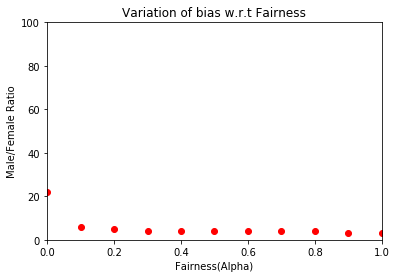

In [4]:
# #########################For other plot#######################
import numpy as np
u1,R= ProPub22()
y_1,y_train=ProPub2_svm()

########################################################

ratio=np.zeros(11,dtype=int)
i=0
for alpha in [0,0.1, 0.2, 0.3 ,0.4,0.5, 0.6,0.7,0.8,0.9,1]:
    f  = fair2(y_train,u1,y_1,alpha)
    r=ploting2(R,f) 
    ratio[i]=r
    i=i+1
alpha1=[0,0.1, 0.2, 0.3 ,0.4,0.5, 0.6,0.7,0.8,0.9,1]

import matplotlib.pyplot as plt
plt.plot( alpha1, ratio, 'ro')
plt.axis([0, 1, 0, 100])
plt.xlabel('Fairness(Alpha)')
plt.ylabel('Male/Female Ratio')
plt.title('Variation of bias w.r.t Fairness')
alpha = np.linspace(0, 1, 10) 
y = 4
# fig = plt.figure(figsize = (10, 5)) 
plt.plot(1, y) 

plt.show() 

In [3]:
from random import *
def fair2(x,a,b,alpha):
    #x-actual a=kesper b=classifier
    a_acc=0
    b_acc=0
    f_acc=0
    n= x.shape[0]
    f= np.zeros(n) 
    count=0
    acc=0
    for i in range(n):
        z=random()
        if z < alpha:
            f[i]= a[i] 
            count=count+1
        else:
            f[i]= b[i]
                    
        
    
    for i in range(n):
         if a[i] == x[i]:
                a_acc=a_acc+1
    a_acc_percent=a_acc/n
    
    
    for i in range(n):
         if b[i] == x[i]:
                b_acc=b_acc+1
    b_acc_percent=b_acc/n   
    
    for i in range(n):
         if f[i] == x[i]:
                f_acc=f_acc+1
    f_acc_percent=f_acc/n  
    
    #kasper svm final
    return f
        

def ploting2(R,f):
    count1=0
    count2=0
    for i in range(R.shape[1]):
        if(R[0,i]==1):
            if f[i]==1:
                  count1+=1
        else:
            if f[i]==1:
                count2+=1
            
    ratio=float(count1/count2)        
    return ratio

def ProPub22():
    filename = '13ProPublica_violent_racidivism.csv'

    d2 = pd.read_csv(filename)

    m= d2.shape[1]
    x1 = d2.loc[0:2806,'sex']
    x2 = d2.loc[0:2806,'race']
    n = x1.shape[0]
    R = np.zeros((7, n), dtype = int)
    r = np.zeros((1, n), dtype = int)

    for i in range(n):
        if x1[i] == 'Male':
            R[0][i]= 1
        else:
            R[1][i]= 1

    for i in range(n):
        if x2[i] == 'African-American':
            R[2][i]= 1
        elif x2[i] == 'Caucasian':
            R[3][i]= 1
        elif x2[i] == 'Hispanic':
            R[4][i]= 1
        elif x2[i] == 'Asia':
            R[5][i]= 1
        else:
            R[6][i]= 1


    racidivism_kasper = discrepancy_minimize(R, norm=np.inf, balanced=False, local_search=0.3)
    r = FindDisc(R,racidivism_kasper)

    racidivism1={}
    for i in range(racidivism_kasper.shape[0]):
        if racidivism_kasper[i]==1:
              racidivism1[i]=2      
        else:
            racidivism1[i]=1

    racidivismu1=racidivism1      

    print(racidivismu1)
    for i in range(n):
        print(racidivismu1[i])
    ###################################################

    racidivism2={}
    for i in range(racidivism_kasper.shape[0]):
        if racidivism_kasper[i]==-1:
              racidivism2[i]=2
        else:
            racidivism2[i]=1

    racidivismu2=racidivism2      
    print(racidivismu2)        


    return racidivismu1,R
   

In [ ]:
filename = '2adult.csv'
d2 = pd.read_csv(filename)
n = d2.shape[0]
m= d2.shape[1]
x1 = d2.iloc[:,10]
x2 = d2.iloc[:,9]

R = np.zeros((7, n), dtype = int)
for i in range(n):
    if x1[i] == 'Male':
        R[5][i]= 1
        R[6][i]= 0
    else:
        R[6][i]= 1
        R[5][i]= 0

for i in range(n):
    if x2[i] == 'White':
        R[0][i]= 1
        R[1][i]= 0
        R[2][i]= 0
        R[3][i]= 0
        R[4][i]= 0
    elif x2[i] == 'Asian-Pac-Islander':
        R[0][i]= 0
        R[1][i]= 1
        R[2][i]= 0
        R[3][i]= 0
        R[4][i]= 0
    elif x2[i] == 'Amer-Indian-Eskimo':
        R[0][i]= 0
        R[1][i]= 0
        R[2][i]= 1
        R[3][i]= 0
        R[4][i]= 0
    elif x2[i] == 'Black':
        R[3][i]= 0
        R[2][i]= 0
        R[0][i]= 0
        R[1][i]= 1
        R[2][i]= 0
    else :
        R[4][i]= 0
        R[1][i]= 0
        R[0][i]= 0
        R[1][i]= 0
        R[2][i]= 1



x = discrepancy_minimize(R, norm=np.inf, balanced=False, local_search=0.3)
r = FindDisc(R,x)
# print(x)
print(r,math.sqrt(n*math.log2(m)))

In [ ]:
filename = '4Ricci.csv'
d2 = pd.read_csv(filename)
n = d2.shape[0]
m= d2.shape[1]
x1 = d2.loc[:,'gender']
x2 = d2.loc[:,'Race']  #race
R = np.zeros((3, n), dtype = int)
r = np.zeros((1, n), dtype = int)
count1=0
count_1=0
for i in range(n):
    if x2[i] == 'W':
        R[0][i]= 1 
    elif x2[i] == 'H':
        R[1][i]= 1
    else :
        R[2][i]= 1

ricci = discrepancy_minimize(R, norm=np.inf, balanced=False, local_search=0.3)
r = FindDisc(R,x)



ricci={}
for i in range(ricci_kasper.shape[0]):
    if ricci_kasper[i]==1:
          ricci1[i]=2
            
    else:
        ricci1[i]=1
        
ricciu1=ricci1      
# germanu1=german1[0:698]
print(germanu1)
for i in range(n):
    print(ricciu1[i])
###################################################

ricci2={}
for i in range(ricci_kasper.shape[0]):
    if german_kasper[i]==-1:
          ricci2[i]=2
    else:
        ricci2[i]=1
        
ricci2=ricci2      
print(ricciu2)        



print(r,math.sqrt(n*math.log2(m)))
#0.0 17.464981393780423

In [ ]:
#######german plot################   
for alpha in [0,0.1, 0.2, 0.3 ,0.4,0.5, 0.6,0.7,0.8,0.9,1]:
    a,b,c  = fair(y_train,germanu1,y_1,alpha)
    print(alpha,c)
print("-----------------------------------------------------------")   
for alpha in [0,0.1, 0.2, 0.3 ,0.4,0.5, 0.6,0.7,0.8,0.9,1]:
    a,b,c  = fair(y_train,germanu2,y_1,alpha)
    print(alpha,c)  
import matplotlib.pyplot as plt
plt.plot([0,0.1, 0.2, 0.3 ,0.4,0.5, 0.6,0.7,0.8,0.9,1], [.9384835479256081
, 0.8955650929899857
, 0.8526466380543634, 0.82689556509299, 0.7825464949928469, 0.7381974248927039,0.6795422031473534
 ,0.6595135908440629,0.6022889842632332, 0.5736766809728183,0.5321888412017167], 'ro')
plt.axis([0, 1, 0, 1])
plt.xlabel('Fairness(Alpha)')
plt.ylabel('Train Accuracy')
plt.title('Accuracy V/S Fairness tradeoff for German dataset')

alpha = np.linspace(0, 1, 10) 
y = alpha*(0.5321888412017167 - .9384835479256081) + .9384835479256081
# fig = plt.figure(figsize = (10, 5)) 

plt.plot(alpha, y) 


plt.legend(["Experimental", "Theoretical"])
plt.show()    

In [ ]:

###############Ricci#####################
# This Python 3 environment comes with many helpful analytics librarie

# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%pylab inline
from random import *
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.
#Reading data from CSV file
df = pd.read_csv('../input/4ricci',dtype=int32)

#Defining data and label
X = df.iloc[:, 0:3]
y = df.iloc[:, 4]




#Split data into training and test datasets (training will be based on 70% of data)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0,shuffle=False) 
#test_size: if integer, number of examples into test dataset; if between 0.0 and 1.0, means proportion
print('There are {} samples in the training set and {} samples in the test set'.format(X_train.shape[0], X_test.shape[0]))


#Scaling data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

sc = StandardScaler(with_mean=False)
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

#X_train_std and X_test_std are the scaled datasets to be used in algorithms

#Applying SVC (Support Vector Classification)
from sklearn.svm import SVC

svm = SVC(kernel='rbf', random_state=0, gamma=.10, C=1.0)
svm.fit(X_train_std, y_train)
print('The accuracy of the SVM classifier on training data is {:.2f}'.format(svm.score(X_train_std, y_train)))
print('The accuracy of the SVM classifier on test data is {:.2f}'.format(svm.score(X_test_std, y_test)))
print('####Train prediction Label###############################################')
y_1=svm.predict(X_train_std)
# print(y_1)

# print(y_1[2:3])
# print(y_1[3:4])
# print(y_1[4:5])
# for i in range(X_train.shape[0]):
#      print(y_1[i])
        
        
print('####Actual Train Label###############################################')
# print(y_train)

# y_train.to_numpy()

# for i in range(X_train.shape[0]):
#     print(y_train[i])

###############################################
print('####Change to colors###############################################')
count=0
for i in range(X_train.shape[0]):
    if y_1[i] == y_train[i]:
        count=count+1
print(count)    

y_trainx=np.zeros((1,X_train.shape[0]),dtype= int)

# for i in range(X_train.shape[0]):
#     if y_train[i]==1:
#         y_trainx[i]=-1
#     else:
#         y_trainx[i]=1
        
        

# for i in range(X_train.shape[0]):
#     if y_1[i]==1:
#         y_1x[i]=-1
#     else:
#         y_1x[i]=1
        


print('####Test###############################################')
y_2=svm.predict(X_test_std)


print(y_2)




a,b,c  = fair(y_train,germanu1,y_1,0.1)
print(a)
print(b)
print(c)

In [ ]:
#######ricci plot ################   
for alpha in [0,0.1, 0.2, 0.3 ,0.4,0.5, 0.6,0.7,0.8,0.9,1]:
    a,b,c  = fair(y_train,ricciu1,y_1,alpha)
    print(alpha,c)
print("-----------------------------------------------------------")   
for alpha in [0,0.1, 0.2, 0.3 ,0.4,0.5, 0.6,0.7,0.8,0.9,1]:
    a,b,c  = fair(y_train,ricciu2,y_1,alpha)
    print(alpha,c) 
    
# import matplotlib.pyplot as plt
# plt.plot([0,0.1, 0.2, 0.3 ,0.4,0.5, 0.6,0.7,0.8,0.9,1], [.9384835479256081
# , 0.8955650929899857
# , 0.8526466380543634, 0.82689556509299, 0.7825464949928469, 0.7381974248927039,0.6795422031473534
#  ,0.6595135908440629,0.6022889842632332, 0.5736766809728183,0.5321888412017167], 'ro')
# plt.axis([0, 1, 0, 1])
# plt.xlabel('Fairness(Alpha)')
# plt.ylabel('Train Accuracy')
# plt.title('Accuracy V/S Fairness tradeoff for German dataset')

# alpha = np.linspace(0, 1, 10) 
# y = alpha*(0.5321888412017167 - .9384835479256081) + .9384835479256081
# # fig = plt.figure(figsize = (10, 5)) 

# plt.plot(alpha, y) 


plt.legend(["Experimental", "Theoretical"])
plt.show()    

In [ ]:
#######1propublica plot################   
for alpha in [0,0.1, 0.2, 0.3 ,0.4,0.5, 0.6,0.7,0.8,0.9,1]:
    a,b,c  = fair(y_train,racidivismu1,y_1,alpha)
    print(alpha,c)
print("-----------------------------------------------------------")   
for alpha in [0,0.1, 0.2, 0.3 ,0.4,0.5, 0.6,0.7,0.8,0.9,1]:
    a,b,c  = fair(y_train,racidivismu2,y_1,alpha)
    print(alpha,c)  
# import matplotlib.pyplot as plt
# plt.plot([0,0.1, 0.2, 0.3 ,0.4,0.5, 0.6,0.7,0.8,0.9,1], [.9384835479256081
# , 0.8955650929899857
# , 0.8526466380543634, 0.82689556509299, 0.7825464949928469, 0.7381974248927039,0.6795422031473534
#  ,0.6595135908440629,0.6022889842632332, 0.5736766809728183,0.5321888412017167], 'ro')
# plt.axis([0, 1, 0, 1])
# plt.xlabel('Fairness(Alpha)')
# plt.ylabel('Train Accuracy')
# plt.title('Accuracy V/S Fairness tradeoff for German dataset')

# alpha = np.linspace(0, 1, 10) 
# y = alpha*(0.5321888412017167 - .9384835479256081) + .9384835479256081
# # fig = plt.figure(figsize = (10, 5)) 

# plt.plot(alpha, y) 


# plt.legend(["Experimental", "Theoretical"])
# plt.show()  

In [ ]:
import matplotlib.pyplot as plt
plt.plot([0,0.1, 0.2, 0.3 ,0.4,0.5, 0.6,0.7,0.8,0.9,1], [
    0.7029657089898054,0.6584800741427247,0.6102873030583874, 
    0.5651065801668211, 0.5016218721037998,0.468952734012975, 
    0.4170528266913809, 0.3681649675625579, 0.31997219647822056, 
    0.26737720111214086,0.22381835032437442], 'ro')
plt.axis([0, 1, 0, 1])
plt.xlabel('Fairness(Alpha)')
plt.ylabel('Train Accuracy')
plt.title('Accuracy V/S Fairness tradeoff for ProPublica dataset')

alpha = np.linspace(0, 1, 10) 
y = alpha*(0.22381835032437442 -  0.7029657089898054) + 0.7029657089898054
# fig = plt.figure(figsize = (10, 5)) 

plt.plot(alpha, y) 


plt.legend(["Experimental", "Theoretical"])
plt.show()  

In [ ]:
######2propublica plot################   

for alpha in [0,0.1, 0.2, 0.3 ,0.4,0.5, 0.6,0.7,0.8,0.9,1]:
    a,b,c  = fair(y_train,racidivismu1,y_1,alpha)
    print(alpha,c)
print("-----------------------------------------------------------")   
for alpha in [0,0.1, 0.2, 0.3 ,0.4,0.5, 0.6,0.7,0.8,0.9,1]:
    a,b,c  = fair(y_train,racidivismu2,y_1,alpha)
    print(alpha,c)  

    
    # import matplotlib.pyplot as plt
# plt.plot([0,0.1, 0.2, 0.3 ,0.4,0.5, 0.6,0.7,0.8,0.9,1], [.9384835479256081
# , 0.8955650929899857
# , 0.8526466380543634, 0.82689556509299, 0.7825464949928469, 0.7381974248927039,0.6795422031473534
#  ,0.6595135908440629,0.6022889842632332, 0.5736766809728183,0.5321888412017167], 'ro')
# plt.axis([0, 1, 0, 1])
# plt.xlabel('Fairness(Alpha)')
# plt.ylabel('Train Accuracy')
# plt.title('Accuracy V/S Fairness tradeoff for German dataset')

# alpha = np.linspace(0, 1, 10) 
# y = alpha*(0.5321888412017167 - .9384835479256081) + .9384835479256081
# # fig = plt.figure(figsize = (10, 5)) 

# plt.plot(alpha, y) 


# plt.legend(["Experimental", "Theoretical"])
# plt.show()  

In [ ]:
import matplotlib.pyplot as plt
plt.plot([0,0.1, 0.2, 0.3 ,0.4,0.5, 0.6,0.7,0.8,0.9,1], [0.8692554328464553,
 0.7866049162807267,
 0.7043106519415746,
 0.6302101888136801,
 0.5603847524047025,
 0.4837905236907731,
 0.38795867474171714,
 0.3060206626291414,
 0.24011400071250447,
 0.15390096188101177,
 0.07659422871392946], 'ro')
plt.axis([0, 1, 0, 1])
plt.xlabel('Fairness(Alpha)')
plt.ylabel('Train Accuracy')
plt.title('Accuracy V/S Fairness tradeoff for ProPublica violent dataset')

alpha = np.linspace(0, 1, 10) 
y = alpha*(0.07659422871392946 - 0.8692554328464553) + 0.8692554328464553
# fig = plt.figure(figsize = (10, 5)) 

plt.plot(alpha, y) 


plt.legend(["Experimental", "Theoretical"])
plt.show()  

In [ ]:
filename = 'diabetes.csv'
raw_data = open(filename, 'rt')
reader = csv.reader(raw_data, delimiter=',', quoting=csv.QUOTE_NONE)
lr = list(reader)
data = np.array(lr).astype('float')
data
n = data.shape[0]
m = data.shape[1]

S = np.zeros((2, n), dtype = int)

for i in range(n):
    for j in range(m):
        if j==0:
            if data[i][j] > 7:
                S[0][i]= 1
            else:
                S[0][i]= 0
        if j==7:
            if data[i][j] > 40:
                S[1][i]= 1
            else:
                S[1][i]= 0
                
print(data)

        
        
x = discrepancy_minimize(S, norm=np.inf, balanced=False, local_search=0.3)
s = FindDisc(S,x)
print(x)
print(s,math.sqrt(n*math.log2(m)))

In [ ]:
filename = 'bpd.csv'
d2 = pd.read_csv(filename)
n = d2.shape[0]
m= d2.shape[1]
x1 = d2.loc[:,'gender']
x2 = d2.loc[:,'race_ethnicity']
R = np.zeros((4, n), dtype = int)
for i in range(n):
    if x1[i] == 'MALE':
        R[0][i]= 1
    else:
        R[0][i]= 0

for i in range(n):
    if x2[i] == 'WHITE':
        R[1][i]= 1
    else:
        R[1][i]= 0

R[2] = Com(R[0])
R[3] = Com(R[1])

x = discrepancy_minimize(R, norm=np.inf, balanced=False, local_search=0.3)
r = FindDisc(R,x)
# print(x)
print(r,math.sqrt(n*math.log2(m)))


In [10]:
filename = '../input/1ProPublica_racidivism.csv'
d2 = pd.read_csv(filename)
# n = d2.shape[0]
m= d2.shape[1]
x1 = d2.loc[0:4315,'sex']
x2 = d2.loc[0:4315,'race']
n=x1.shape[0]
R = np.zeros((7, n), dtype = int)
for i in range(n):
    if x1[i] == 'Male':
        R[0][i]= 1
    else:
        R[1][i]= 1

for i in range(n):
    if x2[i] == 'African-American':
        R[2][i]= 1
    elif x2[i] == 'Caucasian':
        R[3][i]= 1
    elif x2[i] == 'Hispanic':
        R[4][i]= 1
    elif x2[i] == 'Asia':
        R[5][i]= 1
    else:
        R[6][i]= 1

        
m=R.shape[0]
n=R.shape[1]


import pulp as p 
Lp_prob = p.LpProblem('Problem', p.LpMinimize)  
#X[n]=z() n last value of X
X=np.zeros(n+1,dtype=int)
#X[]=0 to n-1
for i in range(n):
    var=print("var_%f",i)
    X[i]=p.LpVariable(var,lowBound=-1,upBound=1)
    
X[n]  =  p.LpVariable("z",lowBound=0)


# objectivefn
Lp_prob +=  X[n]


# constraints
for i in range(2*m):
    if i<m:
        cons=""
        for j in range(n):    
               if R[j]==1
                 X=print("X[%f]",j)
                cons= cons+str(X[j])
    
    else:
        
    
        





# import the library pulp as p 
# import pulp as p 
  
# # Create a LP Minimization problem 
# Lp_prob = p.LpProblem('Problem', p.LpMinimize)  
  
    
    
# # Create problem Variables  
# x = p.LpVariable("x", lowBound = 0)   # Create a variable x >= 0 
# y = p.LpVariable("y", lowBound = 0)   # Create a variable y >= 0 
  
# # Objective Function 
# Lp_prob += 3 * x + 5 * y    
  
# # Constraints: 
# Lp_prob += 2 * x + 3 * y >= 12
# Lp_prob += -x + y <= 3
# Lp_prob += x >= 4
# Lp_prob += y <= 3
  
# # Display the problem 
# print(Lp_prob) 
  
# status = Lp_prob.solve()   # Solver 
# print(p.LpStatus[status])   # The solution status 
  
# # Printing the final solution 
# print(p.value(x), p.value(y), p.value(Lp_prob.objective)) 

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 55)

In [ ]:

row=2*m+1
col=n+1
        
C=np.zeros(n+1)
print(R.shape[0],R.shape[1])

C[col-1]=1



A=np.zeros((row,col),dtype=int)
print(A.shape[0],A.shape[1])


for i in range(row):
    if i < m :
        A[i,0]=-1   
A[row-1,0]=-1

print(A[i,0])    


for i in range(row):
    for j in range(col) :
        if (j>0 and i<m):
            A[i,j]=R[i,j-1]
        elif j>0 and i<2*m:
            A[i,j]=-1*R[i-2*m,j-1]
        


B=np.zeros(2*m+1)



        


In [38]:

# import the library pulp as p 
import pandas as pd
import numpy as np
import pulp as p 
filename = '../input/1ProPublica_racidivism.csv'
d2 = pd.read_csv(filename)
# n = d2.shape[0]
m= d2.shape[1]
x1 = d2.loc[0:4315,'sex']
x2 = d2.loc[0:4315,'race']
n=x1.shape[0]
R = np.zeros((7, n), dtype = int)
for i in range(n):
    if x1[i] == 'Male':
        R[0][i]= 1
    else:
        R[1][i]= 1

for i in range(n):
    if x2[i] == 'African-American':
        R[2][i]= 1
    elif x2[i] == 'Caucasian':
        R[3][i]= 1
    elif x2[i] == 'Hispanic':
        R[4][i]= 1
    elif x2[i] == 'Asia':
        R[5][i]= 1
    else:
        R[6][i]= 1
        
m=R.shape[0]
n=R.shape[1] 
# Create a LP Minimization problem 
Lp_prob = p.LpProblem('Problem', p.LpMinimize)  
print( range(n)) 
#X[n]=z() n last value of X
X=p.LpProblem('Problem', p.LpMinimize)
X=np.zeros(n+1,dtype=p.LpVariable)
#X[]=0 to n-1

for i in range(n):
    var=str(i)
    X[i]=p.LpVariable(var,lowBound=-1,upBound=1)
X[n] =  p.LpVariable("z",lowBound=0)

#########objective function#####################
Lp_prob += X[n] 

###############################################

##############constraint#################
for i in range(2*m):
    if i<m:
        Lp_prob += X[n] >= p.lpSum([X[j]*R[i][j] for j in range(n)])
    else:        
        Lp_prob += X[n] >= p.lpSum([-1*X[j]*R[i-m][j] for j in range(n)])
    

#####################################
status = Lp_prob.solve()   # Solver 
print(p.LpStatus[status])   # The solution status 
  
# # Printing the final solution 
for i in range(n):
    if(p.value(X[i])>0):
         print("+1")
    else:
        print("-1")
    print(p.value(X[i]))
    
print(p.value(Lp_prob.objective))    
# objectivefn
# Lp_prob +=  exp

# # Create problem Variables  
# x = p.LpVariable("x", lowBound = 0)   # Create a variable x >= 0 
# y = p.LpVariable("y", lowBound = 0)   # Create a variable y >= 0 
  
# Objective Function 
# Lp_prob += 3 * x + 5 * y    
  
# x="x[0]"

# # Constraints: 
# Lp_prob += 2 * x + 3 * y >= 12
# Lp_prob += -x + y <= 3
# Lp_prob += x >= 4
# Lp_prob += y <= 3
# print(type(Lp_prob)) 
# # Display the problem 
# print(Lp_prob) 
  
# status = Lp_prob.solve()   # Solver 
# print(p.LpStatus[status])   # The solution status 
  
# # Prianting the final solution 
# print(p.value(x), p.value(y), p.value(Lp_prob.objective))   


range(0, 4316)
Optimal
+1
1.0
+1
1.0
+1
1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
-1
-1.0
-1
-1.0
-1
0.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.

1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1

+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
-1
-1.0
+1
1.0
-1
-1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
-1
-1.0
+1
1.0
+1
1.0
-1
-1.0
+1
1.0
+1
1.0
-1
-1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
-1
-1.0
-1
-1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
-1
-1.0
+1
1.0
+1
1.0
-1
-1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
-1
-1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
-1
-1.0
-1
-1.0
-1
-1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
+1
1.0
-1
0.0
-1
-1.0
+1
1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
+1
1.0
-1
-1.0
-1
-1.0
-1
-1.0
+1
1.0
+1
1.0
+1
1.0
-1
-1.0
-1
-1.0
-1
-1.0
+1
1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
+1
1.0
-1
-1.0
-1
-1.0
-1
-1.0
+1
1.0
-1
-1.0
-1
-1.0
+1
1.0
-1
-1.0
-1
-1.0
-1
-1.0
+1
1.0
-1
-1.0
+1
1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
+1
1.0
-1
-1.0
-1
-1.0
+1
1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
+1
1.0
-1
-1.0
+1
1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
+1
1.0
-1
-1.0
+1
1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
-1.0
-1
